In [12]:
from dotenv import load_dotenv

load_dotenv()

True

In [13]:
from typing_extensions import List, TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str
    
graph_builder = StateGraph(AgentState)  

In [14]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o", streaming=True)
small_llm = ChatOpenAI(model="gpt-4o-mini", streaming=True)

In [15]:
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field
from typing import Literal

class Route(BaseModel):
   target: Literal['income_tax', 'llm', 'real_estate_tax'] = Field(
        description="The target for the query to answer"
   )
   
router_system_prompt = """
You are an expert at routing a user's question to 'income_tax', 'llm', or 'real_estate_tax'.
'income_tax' contains information about income tax up to December 2024.
'real_estate_tax' contains information about real estate tax up to December 2024.
if you think the question is not related to either 'income_tax' or 'real_estate_tax';
you can route it to 'llm'."""   

router_prompt = ChatPromptTemplate.from_messages([
    ("system", router_system_prompt),
    ("user", "{query}"),
])
                                                 
structured_router_llm = small_llm.with_structured_output(Route)

def router(state: AgentState) -> Literal['income_tax', 'llm', 'real_estate_tax']:
   """
   주어진 state에서 쿼리를 기반으로 적절한 경로를 결정합니다.
    Args:
         state (AgentState): 에이전트의 현재 상태를 나타내는 딕셔너리.
    
    Returns:
         Literal['income_tax', 'llm', 'real_estate_tax']: 쿼리에 따라 선택된 경로를 반환합니다.
   """
   
   query = state['query']
   router_chain = router_prompt | structured_router_llm
   route = router_chain.invoke({"query": query})
   
   return route.target    

In [16]:
from langchain_core.output_parsers import StrOutputParser

def call_llm(state: AgentState) -> AgentState:
    """
    주어진 state에서 쿼리를 기반으로 LLM을 호출하여 답변을 생성합니다.
    
    Args:
        state (AgentState): 에이전트의 현재 상태를 나타내는 딕셔너리.
    
    Returns:
        AgentState: 'answer' 키에 LLM의 응답을 포함하는 AgentState를 반환합니다.
    """
   
    query = state['query']
    llm_chain = small_llm | StrOutputParser()
    answer = llm_chain.invoke(query)
    
    return {'answer': answer}

### 파일들이 NODE로 사용// 서브그래프 만드는 핵심적인 내용

In [17]:
from income_tax_agent import graph as income_tax_agent
from real_estate_tax_graph import graph as real_estate_tax_agent

graph_builder.add_node('income_tax', income_tax_agent)
graph_builder.add_node('real_estate_tax', real_estate_tax_agent)
graph_builder.add_node('llm', call_llm)

In [18]:
from langgraph.graph import START, END

graph_builder.add_conditional_edges(
    START,
    router,
    {
        'income_tax': 'income_tax',
        'real_estate_tax': 'real_estate_tax',
        'llm': 'llm'
    }
)

graph_builder.add_edge('income_tax', END)
graph_builder.add_edge('real_estate_tax', END)
graph_builder.add_edge('llm', END)

In [19]:
graph = graph_builder.compile()

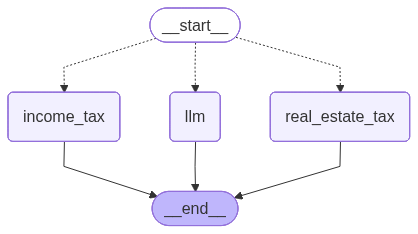

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
initial_state = {'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?'}
graph.invoke(initial_state)

거짓말:  not hallucinated
유용성: helpful


{'query': '연봉 5천만원 거주자의 소득세는 얼마인가요?',
 'context': [Document(metadata={'source': './tax.docx'}, page_content='제55조(세율) ①거주자의 종합소득에 대한 소득세는 해당 연도의 종합소득과세표준에 다음의 세율을 적용하여 계산한 금액(이하 “종합소득산출세액”이라 한다)을 그 세액으로 한다. <개정 2014. 1. 1., 2016. 12. 20., 2017. 12. 19., 2020. 12. 29., 2022. 12. 31.>\n\n| 종합소득 과세표준          | 세율                                         |\n\n|-------------------|--------------------------------------------|\n\n| 1,400만원 이하     | 과세표준의 6퍼센트                             |\n\n| 1,400만원 초과     5,000만원 이하     | 84만원 + (1,400만원을 초과하는 금액의 15퍼센트)  |\n\n| 5,000만원 초과   8,800만원 이하     | 624만원 + (5,000만원을 초과하는 금액의 24퍼센트) |\n\n| 8,800만원 초과 1억5천만원 이하    | 3,706만원 + (8,800만원을 초과하는 금액의 35퍼센트)|\n\n| 1억5천만원 초과 3억원 이하         | 3,706만원 + (1억5천만원을 초과하는 금액의 38퍼센트)|\n\n| 3억원 초과    5억원 이하         | 9,406만원 + (3억원을 초과하는 금액의 38퍼센트)   |\n\n| 5억원 초과      10억원 이하        | 1억 7,406만원 + (5억원을 초과하는 금액의 42퍼센트)|\n\n| 10억원 초과        | 3억 8,406만원 + (10억원을 초과하는 금액의 45퍼센트)|\n\n\n\n\n\n② 거주자의 퇴직소득에 대한 소득세는 다음 

In [22]:
initial_state = {'query': '집 15억은 세금이 얼마인가요?'}
graph.invoke(initial_state)

{'query': '집 15억은 세금이 얼마인가요?',
 'answer': '사용자가 소지한 주택의 수에 따라 종합부동산세를 계산할 수 있습니다. 현재 주어진 정보로는 공정시장가액비율이 제공되지 않았으므로, 이 비율을 가정하여 계산해야 합니다. 일반적으로 공정시장가액비율은 60%에서 100% 사이로 설정됩니다.\n\n예를 들어, 공정시장가액비율을 80%로 가정하고 계산해 보겠습니다.\n\n1. **1세대 1주택자**일 경우:\n   - 과세표준 = 3억 원 × 80% = 2억 4천만 원\n   - 세율: 3억 원 이하이므로 1천분의 5\n   - 종합부동산세 = 2억 4천만 원 × 0.0005 = 120만 원\n\n2. **법인 또는 법인으로 보는 단체**일 경우:\n   - 과세표준 = 9억 원 × 80% = 7억 2천만 원\n   - 세율: 6억 원 초과 12억 원 이하이므로 360만 원 + (6억 원을 초과하는 금액의 1천분의 10)\n   - 6억 원 초과 금액 = 1억 2천만 원\n   - 추가 세금 = 1억 2천만 원 × 0.001 = 120만 원\n   - 종합부동산세 = 360만 원 + 120만 원 = 480만 원\n\n3. **그 외의 경우**일 경우:\n   - 과세표준 = 6억 원 × 80% = 4억 8천만 원\n   - 세율: 3억 원 초과 6억 원 이하이므로 150만 원 + (3억 원을 초과하는 금액의 1천분의 7)\n   - 3억 원 초과 금액 = 1억 8천만 원\n   - 추가 세금 = 1억 8천만 원 × 0.0007 = 126만 원\n   - 종합부동산세 = 150만 원 + 126만 원 = 276만 원\n\n이 계산은 공정시장가액비율을 80%로 가정한 경우입니다. 실제 공정시장가액비율을 확인한 후, 해당 비율을 적용하여 다시 계산해야 합니다.'}

In [23]:
initial_state = {'query': '떡볶이는 어디가 맛있나요?'}
graph.invoke(initial_state)

{'query': '떡볶이는 어디가 맛있나요?',
 'answer': '떡볶이는 서울을 비롯한 한국 전역에서 맛볼 수 있지만, 특히 유명한 지역과 가게들이 있습니다. 몇 가지 추천드리자면:\n\n1. **신당동 떡볶이**: 서울의 신당동은 떡볶이 골목으로 유명합니다. 다양한 가게들이 모여 있어 여러 가지 스타일의 떡볶이를 즐길 수 있습니다.\n\n2. **이태원**: 이태원에는 외국인 관광객들에게 인기 있는 떡볶이 가게들이 많습니다. 다양한 퓨전 떡볶이도 시도해볼 수 있습니다.\n\n3. **홍대**: 홍대 주변에도 많은 떡볶이 가게가 있으며, 젊은 층에게 인기가 많습니다. 다양한 토핑과 함께 제공되는 떡볶이를 맛볼 수 있습니다.\n\n4. **부산**: 부산의 자갈치 시장 근처에서도 유명한 떡볶이 가게가 있습니다. 해산물 떡볶이도 인기입니다.\n\n각 지역마다 특색 있는 떡볶이를 제공하니, 여행 중에 다양한 곳을 시도해보시는 것도 좋습니다!'}